# INSTAGRAM: DETECCIÓN DE USUARIOS FALSOS

## **Entrenamiento y evaluación de modelos**

<img src="https://miracomohacerlo.com/wp-content/uploads/2019/02/como-ver-a-que-fotos-le-da-like-en-instagram-una-persona-2.jpg" />

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

## **DATASET**

In [3]:
dataset_original = pd.read_csv('instagram.csv')
dataset = dataset_original

renamed_columns = {'pos':'post','flw':'followers','flg':'following','bl':'biography_lenght','pic':'profile_picture','lin':'external_url','cl':'post_lenght','cz':'post_lenght_null','ni':'none_image','erl':'engagement_rate_likes','erc':'engagement_rate_comments','lt':'post_location','hc':'hashtags_post','pr':'hashtags_promotional','fo':'hashtags_followers','cs':'cosine_similarity','pi':'interval_post','class':'user_class'}
dataset.rename(columns = renamed_columns, inplace = True)

dataset["user_class"] = dataset.user_class.replace(['f','r'], [0, 1])

### **Train, Validation, Test**

In [4]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

## **MÉTRICAS**

Elegimos la métrica **Precision** ya que al momento de predecir queremos estar seguros de que una cuenta falsa realmente lo sea. No nos daría lo mismo que el modelo prediga que una cuenta es falsa si no lo es a que prediga que es verdadera cuando en realidad es falsa. Nos interesa saber del total de cuentas falsas predichas cuales realmente lo fueron. 
Bajo este sustento no podríamos utilizar **Acurracy** porque tiene diferente impacto errar en la predicción de una clase u otra. A su vez creemos que tampoco nos parece adecuado utilizar **Recall** porque se le estaría dando un tratamiento inapropiado a cuentas que se clasificaron como falsas pero que en realidad eran verdaderas. 

Si bien a continuación vamos a evaluar los modelos con todas las métricas, le vamos a dar mas importancia a Precision. 


## FEATURE ENGINEERING

### Binning: 
Utilizamos la técnica de redondeo para las siguientes variables:
- post
- followers
- followings
- biography_lenght
- post_lenght
- engagement_rate_likes
- engagement_rate_comments
- hashtags_post
- hashtags_promotional
- hashtags_followers
- interval_post

### One-hotEnconder:
Generamos nuevas columnas a partir de las siguientes variables:
- Profile_picture
- External_URL

Consideramos que las siguientes variables no necesitan una transformación ya que contienen valores que corresponden a porcentajes entre 0 y 1:
- post_lenght_null
- none_image
- post_location
- cosine_similarity

### **MAPPER**

In [5]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [6]:
mapper = DataFrameMapper([
    (['post'], [StandardScaler()]),
    (['followers'], [StandardScaler()]),
    (['following'], [StandardScaler()]),
    (['biography_lenght'], [StandardScaler()]),
    (['profile_picture'], [OneHotEncoder()]),
    (['external_url'], [OneHotEncoder()]),
    (['post_lenght'], [StandardScaler()]),
    (['post_lenght_null'], None),
    (['none_image'], None),
    (['engagement_rate_likes'], [StandardScaler()]),
    (['engagement_rate_comments'], [StandardScaler()]),
    (['post_location'], None),
    (['hashtags_post'], [StandardScaler()]),
    (['hashtags_promotional'], [StandardScaler()]),
    (['hashtags_followers'], [StandardScaler()]),
    (['cosine_similarity'], None),
    (['interval_post'], [StandardScaler()])
])

mapper.fit(train)
mapper.transform(train)

array([[-0.18253881,  0.00945336,  1.9652684 , ..., -0.09823172,
         0.33875901, -0.49296915],
       [-0.25621229,  0.06780201,  1.92669664, ..., -0.09823172,
         0.083333  , -0.4329679 ],
       [-0.1656553 ,  0.00945336, -0.84584119, ..., -0.09823172,
         0.62228298, -0.51249225],
       ...,
       [-0.25621229, -0.04629204,  1.9652684 , ..., -0.09823172,
         0.166667  , -0.50160501],
       [-0.26695634, -0.04992761, -0.8350411 , ..., -0.09823172,
         0.        ,  0.21571928],
       [-0.26695634, -0.04000834,  1.9652684 , ..., -0.09823172,
         1.        , -0.43604877]])

In [7]:
mapper.transformed_names_

['post',
 'followers',
 'following',
 'biography_lenght',
 'profile_picture_x0_0',
 'profile_picture_x0_1',
 'external_url_x0_0',
 'external_url_x0_1',
 'post_lenght',
 'post_lenght_null',
 'none_image',
 'engagement_rate_likes',
 'engagement_rate_comments',
 'post_location',
 'hashtags_post',
 'hashtags_promotional',
 'hashtags_followers',
 'cosine_similarity',
 'interval_post']

## **MODELOS**

### **Función para evaluar modelos**

In [8]:
from sklearn import metrics

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [9]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.user_class
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['real', 'fake'])
            ax.yaxis.set_ticklabels(['real', 'fake'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')
        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### **REGRESIÓN LOGÍSTICA**

In [10]:
from sklearn.linear_model import LogisticRegression

,Accuracy,Precision,Recall,F1
train,0.810103,0.795873,0.832805,0.813920
validation,0.805817,0.787848,0.831813,0.809234


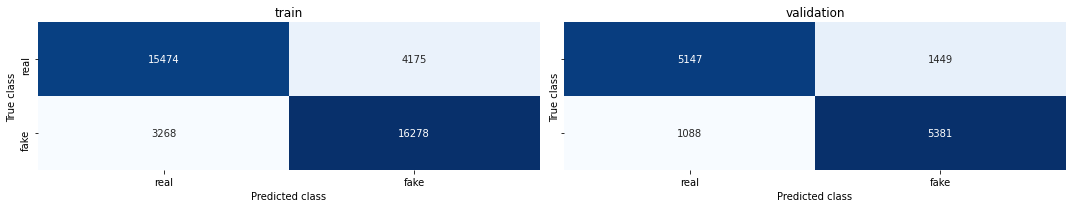

In [11]:
model_lr = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

model_lr.fit(train, train.user_class)

evaluate_model(model_lr)

Podemos observar que **en validation obtuvimos un 80% en la métrica Precision**. A su vez observamos que si bien es muy poca la diferencia de los casos reales que erró con los casos falsos que erró, esta última resulta mayor.

#### Importancias de variables

<AxesSubplot:xlabel='coeficiente', ylabel='feature'>

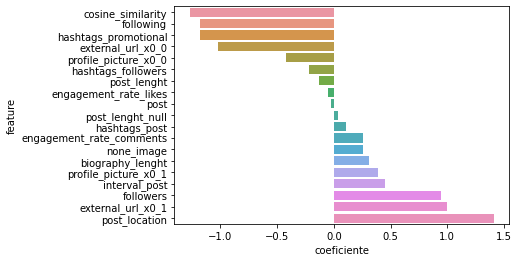

In [12]:
clf = model_lr.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

df_importance = pd.DataFrame({
    'feature': mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

**Conclusiones:**
- Cuanto mas cantidad de following tenga un cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas cantidad de uso de hashtags promocionales tenga una cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas porcentaje de publicaciones con ubicación tenga una cuenta, mas probabilidades tiene de ser real. 
- Si la variable external_URL es 0, mas probabilidades hay de que la cuenta sea falsa. En cambio si es 1 de que sea real.


### **K NEAREST NEIGHBORS**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.852047,0.839684,0.869283,0.854227
validation,0.823728,0.808319,0.844180,0.825860


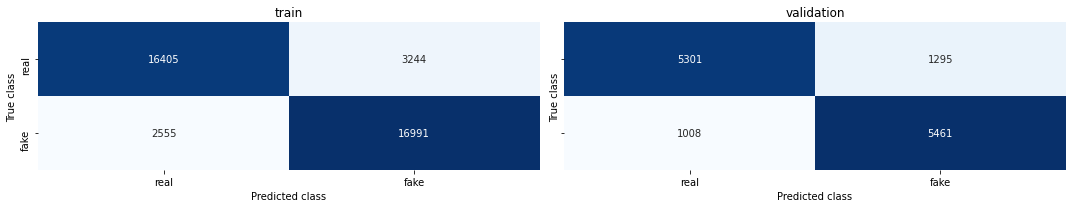

In [14]:
K = 10

model_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

model_knn.fit(train, train.user_class)

evaluate_model(model_knn, title='Knn')

Observamos que en validation obtuvimos en Train un **84% de acierto** en las predicciones del modelo y en Validation **81%**

### **ÁRBOLES DE DECISIÓN**

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.857865,0.858855,0.853146,0.855991


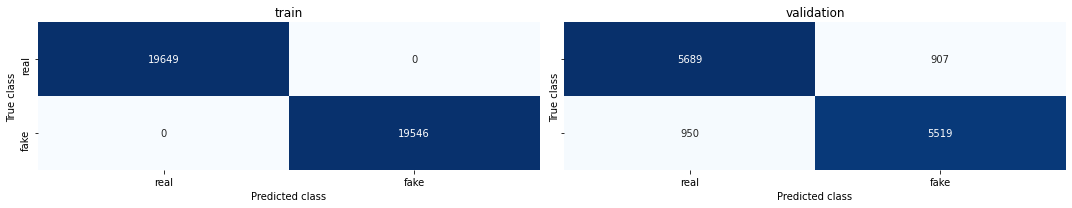

In [16]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

Podemos observar que **en train el algorítmo acertó casi todos los casos**. Sin embargo en validation observamos que si tuvo fallas a la hora de predecir por lo que entendemos que en train está haciendo **overfiting.** 

Por lo cual agregamos un valor de máxima profundidad: 

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.909912,0.867704,0.966745,0.914551
validation,0.886797,0.843569,0.946978,0.892288


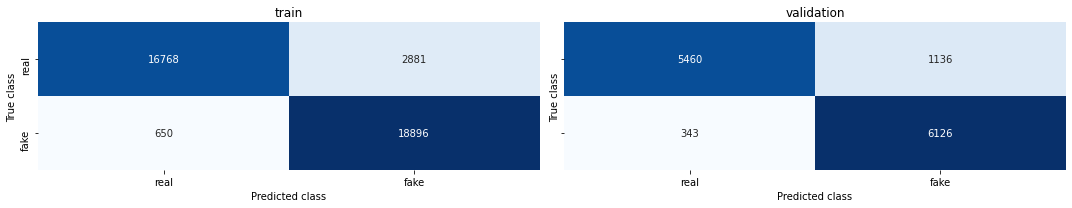

In [17]:
model_tree_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = 10, random_state=42)),
])

model_tree_maxdepth.fit(train, train.user_class)

evaluate_model(model_tree_maxdepth, title='Decision Tree')

Agregando un límite de profundidad obtuvimos mejores resultados con **84% de precision** en train

### **RANDOM FOREST**

In [18]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,1.00000,1.000000,1.00000,1.000000
validation,0.89667,0.854649,0.95347,0.901359


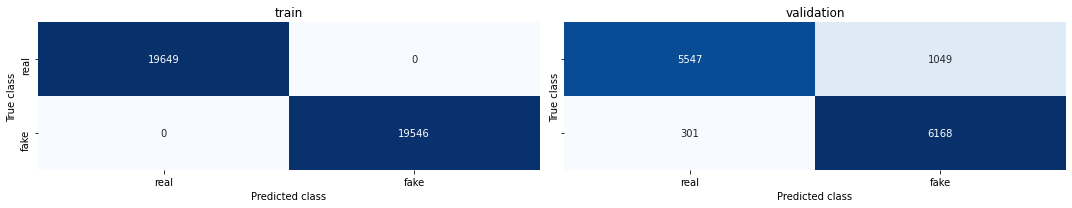

In [19]:
forest_model = RandomForestClassifier(random_state=42)

model_rf = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

model_rf.fit(train, train.user_class)

evaluate_model(model_rf, title='Random Forest')

Observamos que al no indicar un límite de profundidad y cantidad de estimadores obtenemos una precisión de 1, por lo que entendemos que el algorítmo **está sobreentrenando.** 

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.911213,0.854627,0.990433,0.917532
validation,0.890700,0.833708,0.973412,0.898160


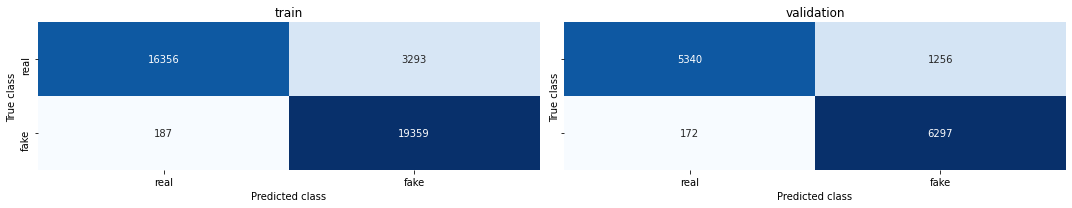

In [20]:
forest_model_maxdepth = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=5, random_state=42)

model_rf_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth),
])

model_rf_maxdepth.fit(train, train.user_class)

evaluate_model(model_rf_maxdepth, title='Random Forest')


Observamos que, para un valor de **100 arboles** y un **limite de profudidad de 10,** obtenemos un **85% de precisión** en Train y un **83%** en Validation. 


### **GRADIENT BOOSTED TREES**

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.904044,0.859977,0.964647,0.909310
validation,0.894221,0.848377,0.957490,0.899637


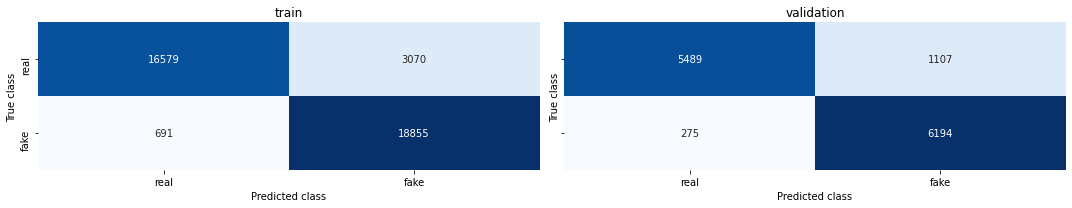

In [22]:
boost_model = GradientBoostingClassifier(random_state=42)

model_gradient_boosted = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

model_gradient_boosted.fit(train, train.user_class)

evaluate_model(model_gradient_boosted, title='Gradient Boosting')

Observamos que en validation obtuvimos un **85%** en Train y **84%** en Validation. 

### EVITANDO OVERFITING

En primer lugar, para identificar si un algoritmo estaba sobreentrenando calculabamos la **matriz de confusión** y observabamos los valores resultantes. Los casos de Train donde los valores eran muy pequeños o 0 nos indicaban que existía overfitting. Al mismo tiempo, en la evaluación de estos algoritmos obteniamos una **precisión del 100%**, lo que también nos indicaba que los algortimos estaban sobreentrenando.

Para evitar el overfitting en estos casos indicamos: 
- Cantidad de vecinos en KNN
- Límite de profundidad en Arboles de Decision 
- Límite de profundidad en Random Forest

Ahora bien para saber cuál debería ser la cantidad de vecinos o máxima profundidad mas apropiada para indicarle a los modelos, graficamos las **curvas de aprendizaje** y a partir de ello seleccionamos el valor mas eficiente.


#### Curva para KNN

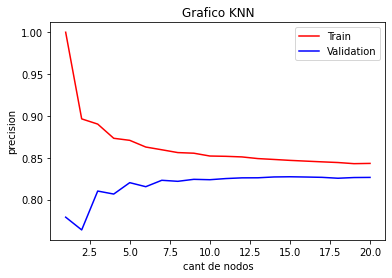

In [24]:
train_prec =  []
eval_prec = []
max_k = list(range(1, 21))

for k in max_k:
    
    model_knn_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=k)),
    ])
    
    knn=model_knn_curva    
    knn=knn.fit(train, train.user_class)    
    train_prec.append(knn.score(train, train.user_class))
    # print(knn.score(train, train.user_class))
    eval_prec.append(knn.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_k, train_prec, color='r', label='Train')
plt.plot(max_k, eval_prec, color='b', label='Validation')
plt.title('Grafico KNN')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

El valor de k mas eficiente se debe encontrar entre 5 y 10. A partir de 10 la curva de aprendizaje se estanca y el algoritmo deja de aprender.

#### Curva para Arboles de decisión 

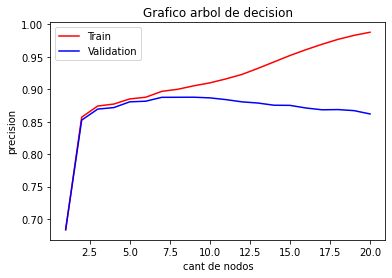

In [26]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))

for deep in max_deep_list:
    
    model_tree_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = deep, random_state=42)),
    ])
     
    arbol_tree=model_tree_maxdepth_curva    
    arbol_tree=arbol_tree.fit(train, train.user_class)    
    train_prec.append(arbol_tree.score(train, train.user_class))
    #print(arbol_tree.score(train, train.user_class))
    eval_prec.append(arbol_tree.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

En el gráfico observamos que entre los valores 5 y 7,5 las curvas se van separando, y a su vez a partir de 10 la curva de validation comienza a caer por lo que a partir de ese momento podemos inferir que el modelo esta sobreentrenando, ya que en los casos nuevos no está acertado las predicciones. Lo que ocurre es que mientras en train va acertando cada vez mas la predicciones en validation va errando.

#### Curva para Random forest

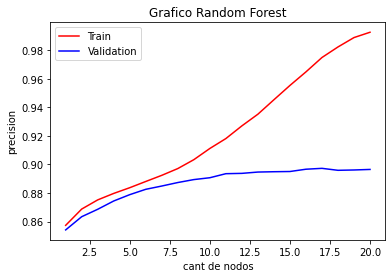

In [27]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))

for deep in max_deep_list:
    
    forest_model_maxdepth_curva = RandomForestClassifier(n_estimators=100, max_depth=deep, max_features=5, random_state=42)

    model_rf_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth_curva),
    ])
    
    arbol_rf=model_rf_maxdepth_curva    
    arbol_rf=arbol_rf.fit(train, train.user_class)    
    train_prec.append(arbol_rf.score(train, train.user_class))
    #print(arbol_rf.score(train, train.user_class))
    eval_prec.append(arbol_rf.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico Random Forest')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

A medida que avanzan las iteraciones, observamos que la métrica en validation no mejora. A partir del valor 10 aproximadamente la curva se estanca.

### EVALUACIÓN FINAL DE MODELOS - VALOR FINAL DE LA MÉTRICA

In [28]:
evaluate_model(model_lr, title='Regresión Logística', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_knn, title='KNN', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_tree_maxdepth, title='Arbol de decisión', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_rf_maxdepth, title='Random Forest', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_gradient_boosted, title='Gradient Boosting', set_names=('train', 'validation','test'), show_cm=False)

'Regresión Logística'

,Accuracy,Precision,Recall,F1
train,0.810103,0.795873,0.832805,0.813920
validation,0.805817,0.787848,0.831813,0.809234
test,0.805985,0.788859,0.828394,0.808143


'KNN'

,Accuracy,Precision,Recall,F1
train,0.852047,0.839684,0.869283,0.854227
validation,0.823728,0.808319,0.844180,0.825860
test,0.826343,0.808876,0.848410,0.828171


'Arbol de decisión'

,Accuracy,Precision,Recall,F1
train,0.909912,0.867704,0.966745,0.914551
validation,0.886797,0.843569,0.946978,0.892288
test,0.888948,0.847868,0.944298,0.893489


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.911213,0.854627,0.990433,0.917532
validation,0.890700,0.833708,0.973412,0.898160
test,0.894459,0.838275,0.973933,0.901026


'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.904044,0.859977,0.964647,0.909310
validation,0.894221,0.848377,0.957490,0.899637
test,0.896449,0.850785,0.958107,0.901262


**Modelo elegido: Gradient Boosting**

**Precision: 85%**

### Conclusión final

Observando los resultados de las métricas para los modelos Regresion Logística, KNN y Arboles de decision, obtenemos que el mejor resultado para Precision es Arboles de Decisión ya que arroja un 84%. 

Por otro lado, comparando los resultados de todos los modelos, concluimos que **Arboles de decision, Random Forest y Gradient Boosting poseen resultados muy cercanos**, el mejor valor de precisión es el que devuelve **Gradient Boosting con 85%** por lo que es el modelo elegido. 
Por lo cual el modelo Gradient Boosting va a acertar un 85 % de las veces cuando prediga que una cuenta es falsa.
